In [40]:
from datetime import date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import statsmodels.api as sm
from scipy import interpolate
from scipy.stats import boxcox, boxcox_normmax

# Exercises

## 2.

In [69]:
gbl_economy = pd.read_csv("data/tsibbledata/global_economy.csv")
gbl_economy.Year = pd.to_datetime(gbl_economy.Year, format="%Y")
gbl_US = gbl_economy.loc[gbl_economy.Code == 'USA'].copy()

In [70]:
lambda_opt = boxcox_normmax(gbl_US.GDP)
gbl_US["GDP_Trans"] = boxcox(gbl_US.GDP, lmbda=lambda_opt)

/usr/local/opt/miniconda3/envs/ds/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


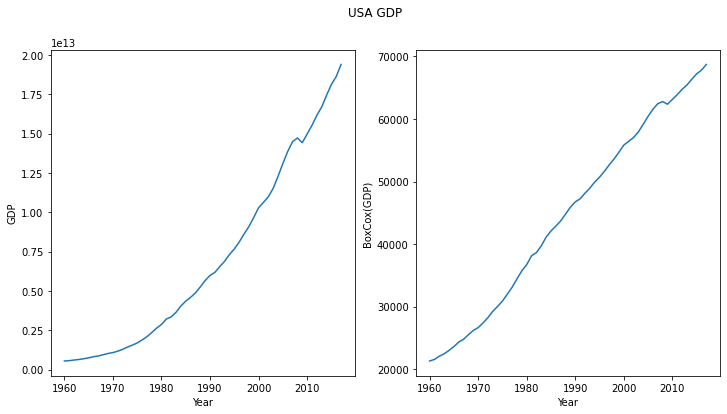

In [71]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
ax1 = sns.lineplot(data=gbl_US, x="Year", y="GDP", ax=axs[0])
ax2 = sns.lineplot(data=gbl_US,x="Year", y="GDP_Trans", ax=axs[1])
ax2.set(ylabel="BoxCox(GDP)")
fig.suptitle("USA GDP");

In [23]:
aus_lstk = pd.read_csv("data/tsibbledata/aus_livestock.csv")
aus_lstk.Month.replace({'Mär':'Mar', 'Mai':'May','Okt':'Oct','Dez':'Dec'}, regex=True, inplace=True)
aus_lstk.Month = pd.to_datetime(aus_lstk.Month, format="%Y %b")

In [88]:
aus_bulls = aus_lstk.loc[(aus_lstk.Animal == "Bulls, bullocks and steers") & (aus_lstk.State == "Victoria")].copy()
aus_bulls["Count_Trans"] = boxcox(aus_bulls.Count)[0]

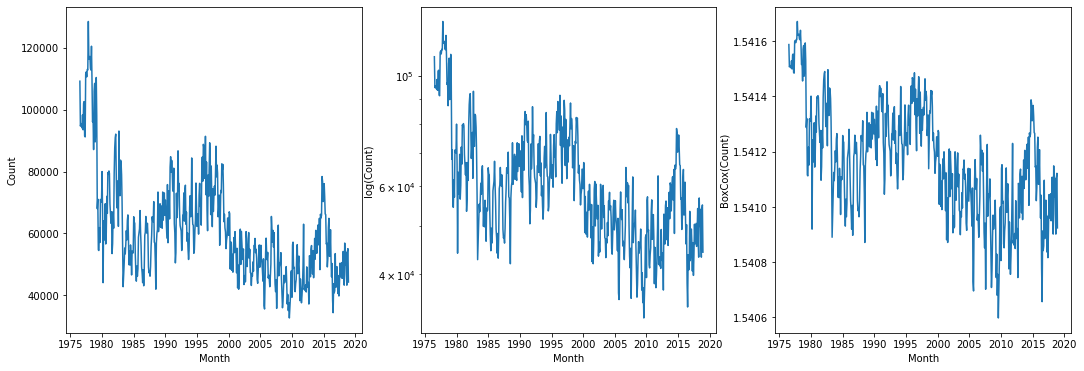

In [87]:
fig, axs = plt.subplots(ncols=3, figsize=(18,6))
ax1 = sns.lineplot(data=aus_bulls, x="Month", y="Count", ax=axs[0])
ax2 = sns.lineplot(data=aus_bulls, x="Month", y="Count", ax=axs[1])
ax3 = sns.lineplot(data=aus_bulls, x="Month", y="Count_Trans")
ax2.set(yscale="log")
ax2.set(ylabel="log(Count)")
ax3.set(ylabel="BoxCox(Count)");

## 3. BoxCox does not help when the variation is not proportional to the level of the time series

In [274]:
ca_gas = pd.read_csv("data/fpp3/canadian_gas.csv")
ca_gas.Month.replace({'Mär':'Mar', 'Mai':'May','Okt':'Oct','Dez':'Dec'}, regex=True, inplace=True)
ca_gas["Month"] = pd.to_datetime(ca_gas.Month, format="%Y %b")

In [100]:
vol_trans, lambda_val = boxcox(ca_gas.Volume)
ca_gas["Volume_Trans"] = vol_trans

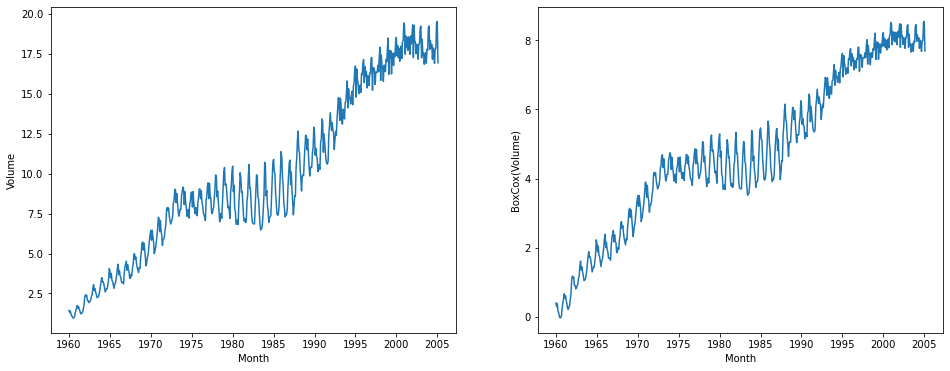

In [102]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
sns.lineplot(data=ca_gas, x="Month", y="Volume", ax=axs[0])
ax2 = sns.lineplot(data=ca_gas, x="Month", y="Volume_Trans", ax=axs[1])
ax2.set(ylabel="BoxCox(Volume)");

## 7.

In [179]:
aus_prod = pd.read_csv("data/tsibbledata/aus_production.csv")

In [180]:
aus_prod["Quarter"] = pd.DatetimeIndex(aus_prod.Quarter.replace({" ": "-"}, regex=True), freq="QS")

In [187]:
min_year = aus_prod.Quarter.dt.year.max() - 5
aus_last5 = aus_prod.loc[aus_prod.Quarter.dt.year > min_year]

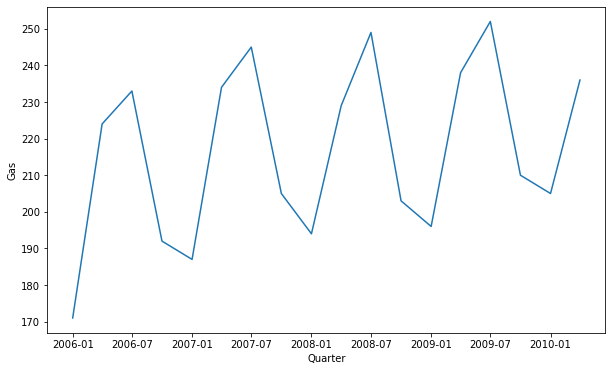

In [191]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=aus_last5, x="Quarter", y="Gas", ax=ax);

a. Strong, increasing trend. Quarterly seasonality that also increases with year

In [192]:
aus_last5.set_index("Quarter", inplace=True)
aus_last5 = aus_last5.asfreq("QS")

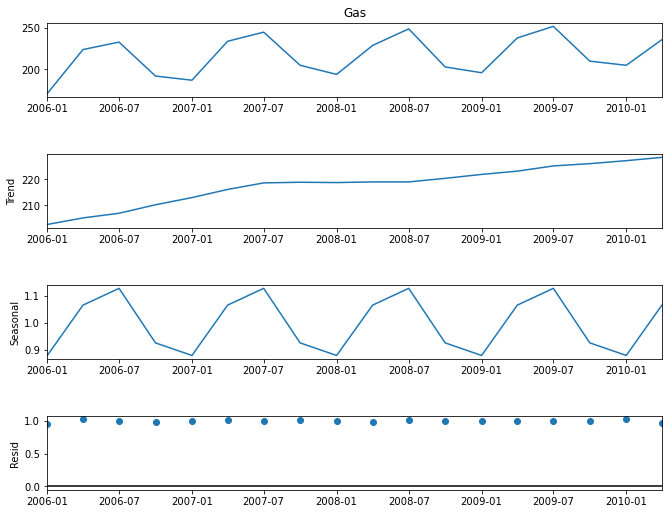

In [193]:
dcomp = sm.tsa.seasonal_decompose(aus_last5.Gas, model="multiplicative", extrapolate_trend=5)
fig = dcomp.plot()
fig.set_size_inches(10, 8)

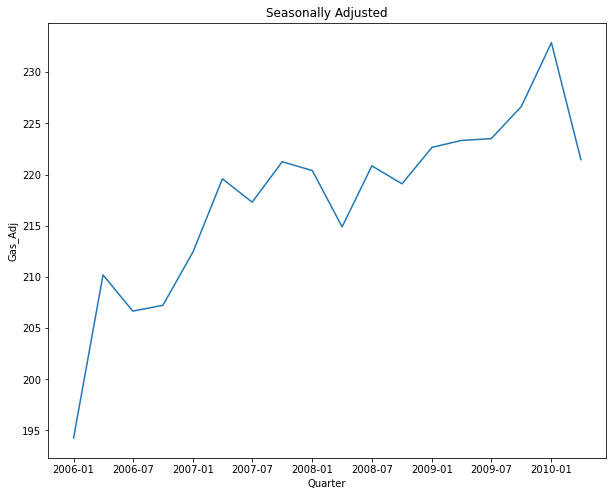

In [198]:
aus_last5["Gas_Adj"] = aus_last5.Gas/dcomp.seasonal
fig = plt.figure(figsize=(10, 8))
sns.lineplot(data=aus_last5, x="Quarter", y="Gas_Adj").set(title="Seasonally Adjusted");

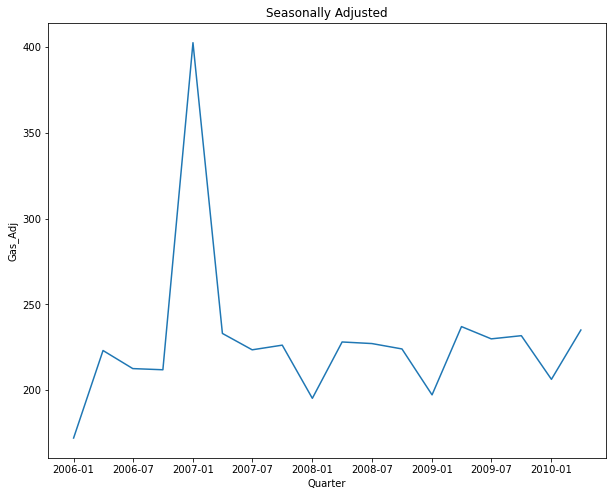

In [232]:
aus_last5_v2 = aus_last5.copy()
aus_last5_v2.loc['2007-01-01', 'Gas'] = 400
dcomp2 = sm.tsa.seasonal_decompose(aus_last5_v2.Gas, model="multiplicative", extrapolate_trend=5)
aus_last5_v2["Gas_Adj"] = aus_last5_v2.Gas/dcomp2.seasonal
fig = plt.figure(figsize=(10, 8))
sns.lineplot(data=aus_last5_v2, x="Quarter", y="Gas_Adj").set(title="Seasonally Adjusted");

## 10.

In [275]:
ca_gas_v2 = ca_gas.copy()
ca_gas_v2["Year"] = ca_gas_v2.Month.dt.year
ca_gas_v2["Month"] = ca_gas_v2.Month.dt.month

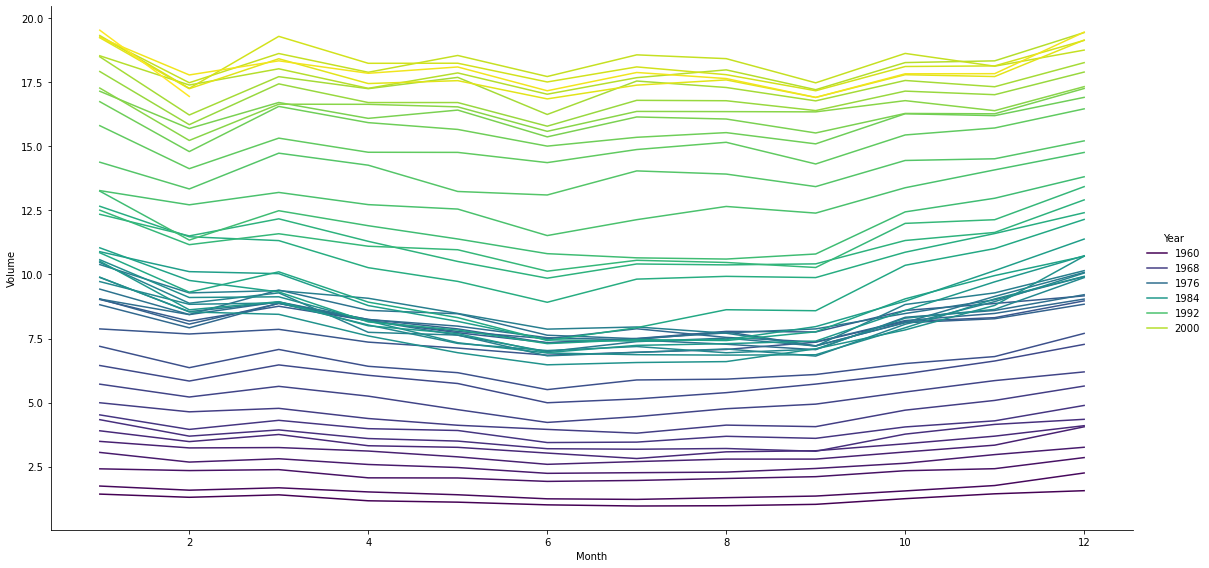

In [245]:
sns.relplot(data=ca_gas_v2, x="Month", y="Volume", hue="Year", kind="line", palette='viridis', height=8, aspect=8/4);

In [257]:
stl_fit = sm.tsa.STL(ca_gas.Volume, robust=True, seasonal=5, period=12).fit()

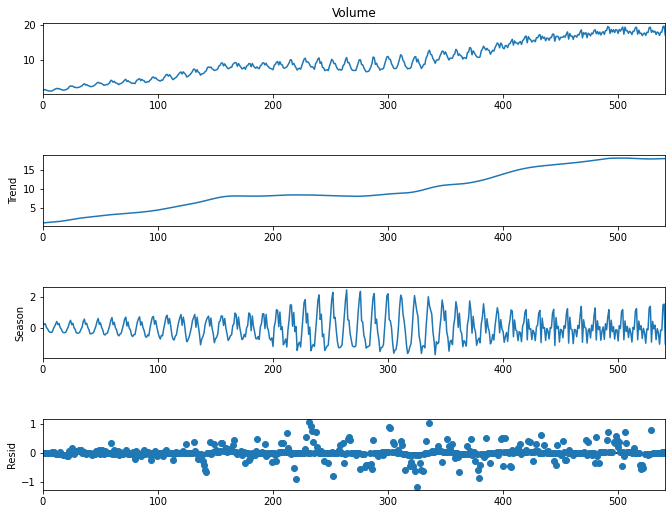

In [258]:
fig = stl_fit.plot()
fig.set_size_inches(10, 8)

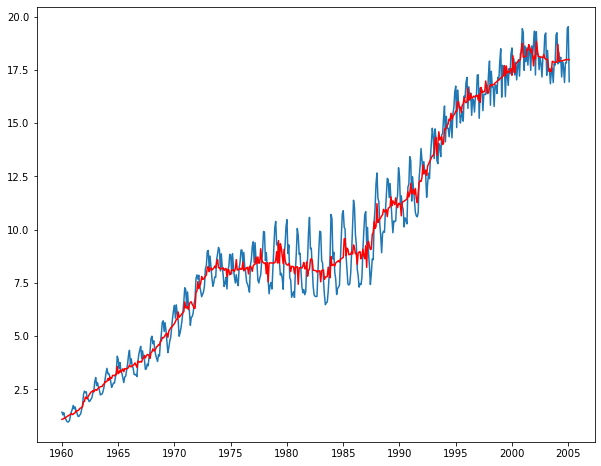

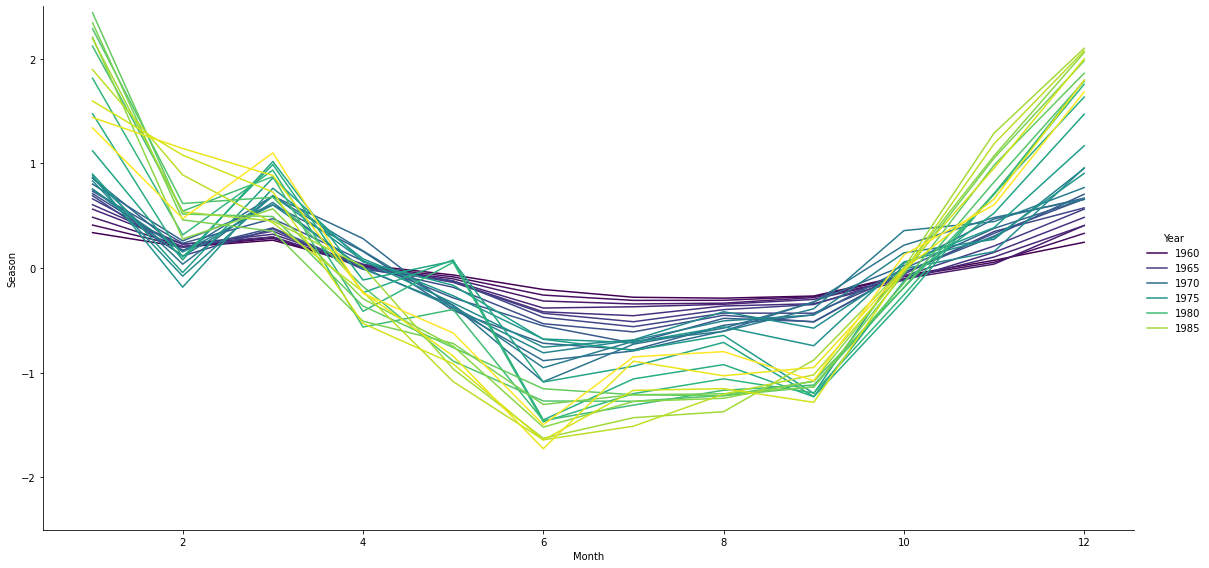

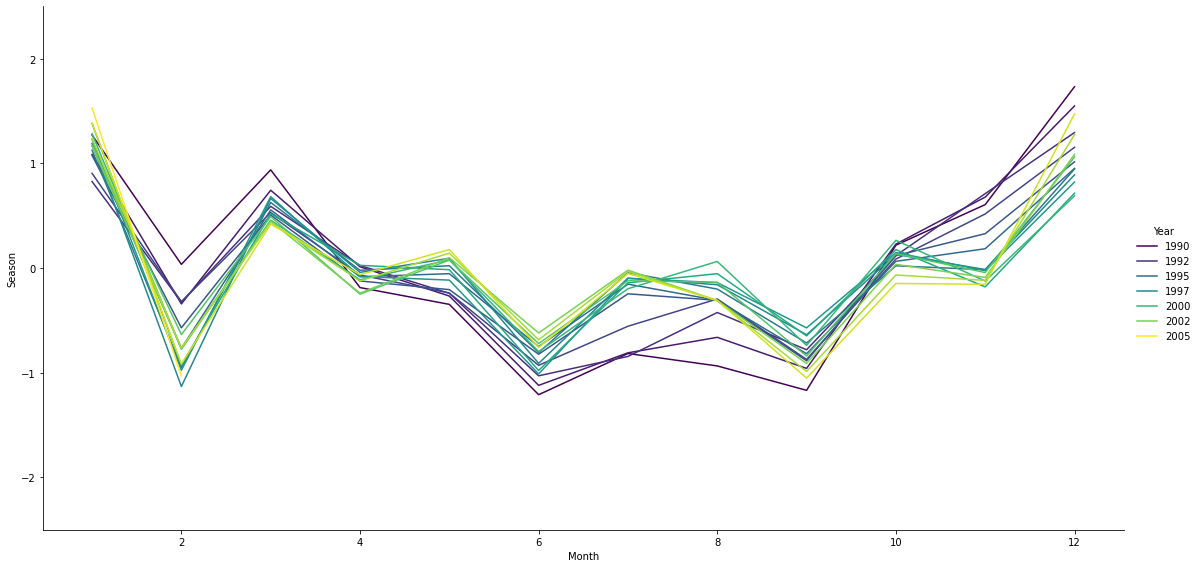

In [284]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(ca_gas.Month, ca_gas.Volume)
ax.plot(ca_gas.Month, ca_gas.Volume-stl_fit.seasonal, color='red')

sns.relplot(data=ca_gas_v2.query("Year < 1990"), x="Month", y="Season", hue="Year", kind='line', height=8, aspect=2, palette='viridis').set(ylim=(-2.5, 2.5))
sns.relplot(data=ca_gas_v2.query("Year >= 1990"), x="Month", y="Season", hue="Year", kind='line', height=8, aspect=2, palette='viridis').set(ylim=(-2.5, 2.5));